## Application: Strikes Duration
---

+ a cross-section from 1968 to 1976
+ number of observations : 566
+ country : United States

#### Variables:

+ dur - duration of the strike in days

+ gdp - measure of stage of business cycle (deviation of monthly log industrial production in manufacturing from prediction from OLS on time, time-squared and monthly dummies)

#### Source:

Kennan, J. (1985) “The Duration of Contract strikes in U.S. Manufacturing”, Journal of Econometrics, 28, 5-28.

#### Reference:

Cameron, A.C. and P.K. Trivedi (2005) Microeconometrics : methods and applications, Cambridge, pp. 574–5 and 582.



In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from IPython.display import display

#### Strikes duration

$$
  p(y_{i}|\theta_{i}) = \frac1{\theta_{i}}e^{-\frac{y_{i}}{\theta_{i}}},\quad
  \theta_{i} = \text{constant} + \beta\text{gdp}.
$$


In [2]:
strikes_data = pd.read_csv('StrikeDur.csv', index_col=0)
strikes_duration = strikes_data['dur'].values
gdp = strikes_data['gdp'].values
y = strikes_duration
X = np.stack((np.ones(len(strikes_duration)), gdp), axis=1)  
var_names = ['constant', 'gdp']

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
exponential_duration_model = pm.Model()
with exponential_duration_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Exponential('y', lam=pm.math.exp(-idx), observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with exponential_duration_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
results = pm.summary(trace, hdi_prob=0.95)
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].values[:, :, index]) for index, var in enumerate(var_names)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [5]:
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,3.785,0.043,3.703,3.868,0.000,0.000,18711.0,15191.0,1.0
gdp,-2.500,0.836,-4.090,-0.829,0.006,0.004,19954.0,15544.0,1.0


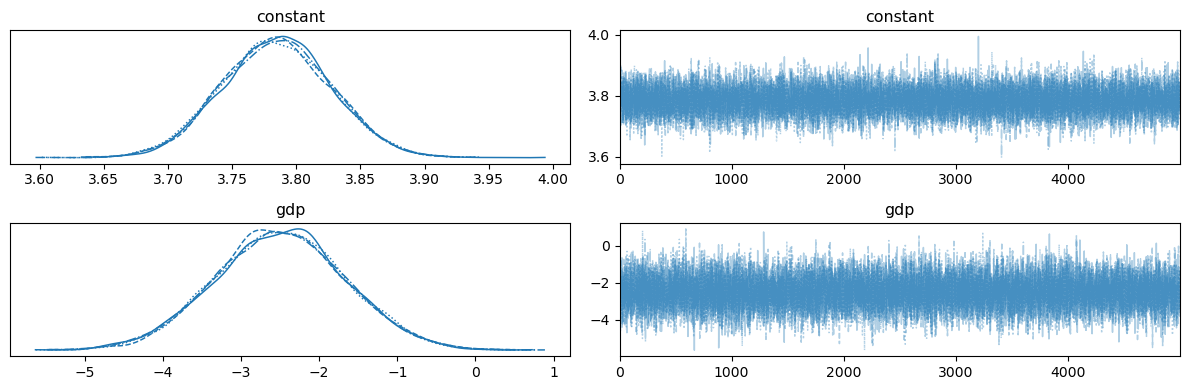

In [6]:
pm.plot_trace(sim_param)
plt.tight_layout()
plt.show()

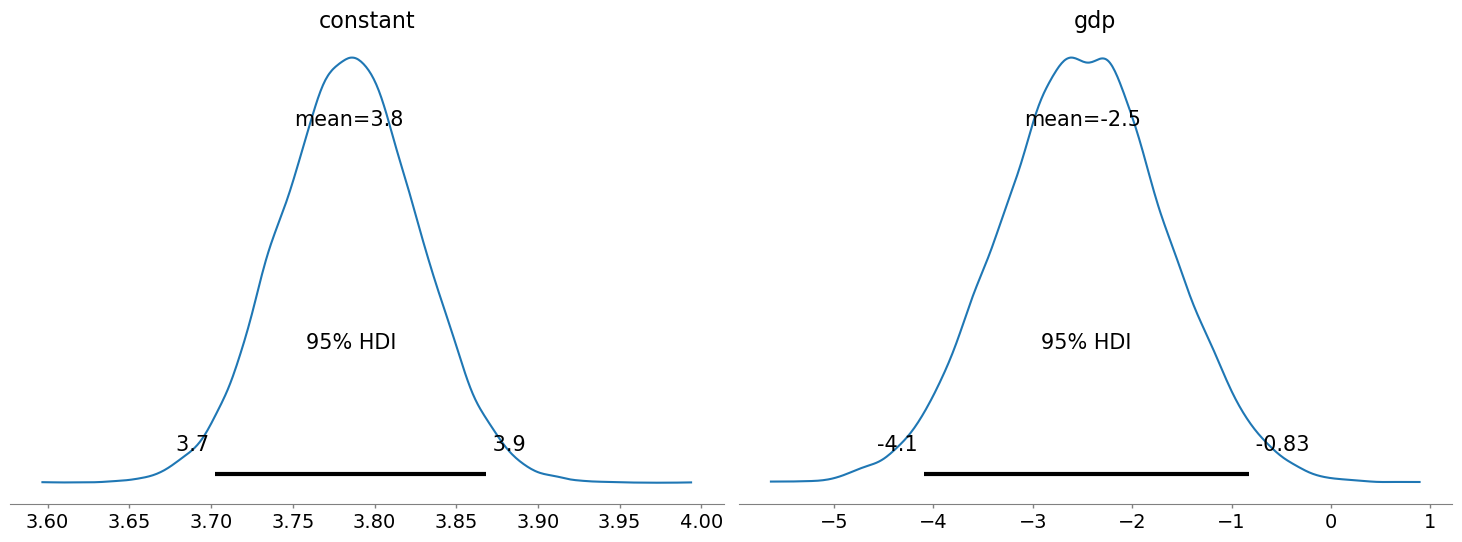

In [7]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()